# Model Implementation
This file will focus on the following:
- Benchmark model(s)to understand current state
- Text data model preparation
- Model implementation and trials
- Results/summary

In [47]:
import pandas as pd
import numpy as np
import re
import gc

In [48]:
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler

In [49]:
import matplotlib.pyplot as plt

In [50]:
# code copied from https://www.kaggle.com/marknagelberg/rmsle-function
def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

# Read Data

In [51]:
clean_data = pd.read_csv(
    '/Users/joashc/Downloads/mercari-price-suggestion-challenge/partially_clean_train_data.csv')
clean_data.shape

(1482486, 13)

## Benchmark Model

### 2 Benchmark Model Descriptions
- Benchmark Model 1: Assume normal distribution for price (not the case) and randomly output prices for all rows in the training data
- Benchmark Model 2: I hypothesize that this will work the best. Input the median as predicted price for each row.

### Evaluation Criteria
- The competition states to use RMSLE (i.e logrithmic RMSE). I will use RMSE and RMSLE to gauge the performance of all models used to predict price.

Below is a historgram of the price column (without outliers)

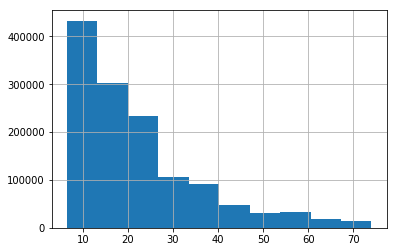

In [52]:
price_wo_outliers =clean_data[(clean_data['price']>clean_data.price.quantile(.05)) & 
                     (clean_data['price']<clean_data.price.quantile(.95))]
price_wo_outliers.price.hist()

### Benchmark Model 1

In [53]:
mean = clean_data[(clean_data['price']>clean_data['price'].quantile(0.05)) &
                  (clean_data['price']<clean_data['price'].quantile(0.95))].price.mean()
std_dev = clean_data[(clean_data['price']>clean_data['price'].quantile(0.05)) &
                  (clean_data['price']<clean_data['price'].quantile(0.95))].price.std()
print('The mean and standard deviation are (took out outliers):', round(mean,2), ',',round(std_dev,2))

The mean and standard deviation are (took out outliers): 21.83 , 13.97


I do not want negative values in the price. The code has a while loop to keep predicting price assuming a normal distribution until all rows are non-negative

In [54]:
price_prediction = pd.DataFrame(
    np.random.normal(mean, std_dev, clean_data.shape[0]), columns=['price_prediction'])

# this while loop is to make sure there are no negative values for the price
num_neg = 1
while num_neg > 0:
    price_prediction['price_prediction'] = price_prediction['price_prediction'].apply(
        lambda x: np.random.normal(mean, std_dev, 1)[0] if x<=0 else x)

    num_neg = price_prediction[price_prediction['price_prediction']<=0].shape[0]
    print('Only', num_neg, 'rows have negative values...')

Only 5360 rows have negative values...
Only 279 rows have negative values...
Only 17 rows have negative values...
Only 0 rows have negative values...


In [55]:
print('RMSE of normal distrubition benchmark model 1 is:', 
      round(np.sqrt(mean_squared_error(clean_data['price'],price_prediction['price_prediction'])), 2))

print()

print('RMSLE of normal distrubition benchmark model 1 is:',
      round(rmsle(clean_data['price'],price_prediction['price_prediction']),2))

RMSE of normal distrubition benchmark model 1 is: 40.66

RMSLE of normal distrubition benchmark model 1 is: 1.01


### Benchmark Model 2

In [56]:
median = clean_data[(clean_data['price']>clean_data['price'].quantile(0.05)) &
                  (clean_data['price']<clean_data['price'].quantile(0.95))].price.median()
print('The median is (took out outliers):', round(median,2))

The median is (took out outliers): 17.0


In [57]:
### Model error if median is inputted for every price
price_data = clean_data[['price']].copy()
price_data['median_price'] = median

print('RMSE of normal distrubition benchmark model 2 is:', 
      round(np.sqrt(mean_squared_error(price_data['price'],price_data['median_price'])), 2))

print()

print('RMSLE of normal distrubition benchmark model 2 is:',
      round(rmsle(price_data['price'],price_data['median_price']),2))

RMSE of normal distrubition benchmark model 2 is: 39.8

RMSLE of normal distrubition benchmark model 2 is: 0.75


- Benchmark model 2 performs marginally better that 1 based on RMSE. However, if you look at RMSLE, it is evident that benchmark model 3 is better. This is because RMSLE uses the log function. This lessens the impact of high errors when the price is a large number.

- 39.8 RMSE and 0.75 RMSLE will be used as the benchmark evaluation criteria for the neural networks model

## Modeling Text
- stemmed_item_description
    - tdidf matrix
- clean_brand_name
    - One-hot-encode
- clean_category_name
    - One-hot-encode
- clean_item_name
    - tdidf matrix

### One-hot-encoding Brand Name

In [12]:
unique_brand_names = pd.DataFrame(clean_data.clean_brand_name.value_counts())
min_brand_freq = 50
print('There are', unique_brand_names[unique_brand_names['clean_brand_name']>=min_brand_freq].shape[0],
      'brand names that occur >=',min_brand_freq, 'times in the dataset.','Will one-hot-encode these brands only.')

There are 813 brand names that occur >= 50 times in the dataset. Will one-hot-encode these brands only.


In [13]:
# one hot encoding all the brand names
clean_brand_name_df = clean_data['clean_brand_name']
clean_brand_name_df = pd.get_dummies(clean_brand_name_df)
clean_brand_name_df.shape

(1482486, 4782)

In [14]:
# dropping all brand names that occur less than a 100 times
drop_brand_col_lst = []
keep_brand_col_lst = list(unique_brand_names[unique_brand_names['clean_brand_name']>=min_brand_freq].index.values)
keep_brand_col_lst.remove('nobrandname')

for col_name in clean_brand_name_df.columns:
    if col_name not in keep_brand_col_lst:
        drop_brand_col_lst.append(col_name)

clean_brand_name_df_v2 =clean_brand_name_df.drop(columns=drop_brand_col_lst)
clean_brand_name_df_v2.columns = ['brand_' + str(col) for col in clean_brand_name_df_v2.columns]
clean_brand_name_df_v2.shape

(1482486, 812)

In [15]:
# Appending the brand name columns to the original dataset
clean_data_v2 = pd.concat([clean_data.reset_index(drop=True)
                                   , clean_brand_name_df_v2.reset_index(drop=True)],
                                  axis=1).drop(columns=['brand_name','clean_brand_name'])
clean_data_v2.shape

(1482486, 823)

Due to the size of the dataset, I have to garbage collect variables that are not in use. This saves AWS instances from going into memory errors

In [16]:
del [[clean_brand_name_df,clean_brand_name_df_v2, clean_data]]
gc.collect()
clean_data = pd.DataFrame()
clean_brand_name_df=pd.DataFrame()
clean_brand_name_df_v2=pd.DataFrame()

### One-hot-encoding Assigned Category and Assigned Sub Category

In [17]:
# one hot encoding category columns
clean_category_name_df = clean_data_v2[['assigned_category', 'assigned_sub_category']]
clean_category_name_df_v2 = pd.get_dummies(clean_category_name_df)
clean_category_name_df_v2.shape

(1482486, 119)

In [18]:
# concat with original dataset
print(clean_data_v2.shape)
clean_data_v3 = pd.concat([clean_data_v2, clean_category_name_df_v2], axis=1)
print(clean_data_v3.shape)

(1482486, 823)
(1482486, 942)


In [19]:
# Delete dataframes from memory
del [[clean_category_name_df,clean_category_name_df_v2, clean_data_v2]]
gc.collect()
clean_data_v2 = pd.DataFrame()
clean_category_name_df=pd.DataFrame()
clean_category_name_df_v2=pd.DataFrame()

### TF-IDF item_description
- Will test out different max features for the tfidf matrix

In [20]:
item_description_df = clean_data_v3['stemmed_item_description']
item_description_df.shape

(1482486,)

In [21]:
max_item_desc_features = 100

In [22]:
# getting the tfidf matrix for the item desc
tfidf = TfidfVectorizer(max_features=max_item_desc_features)
x_tfidf = pd.DataFrame(tfidf.fit_transform(item_description_df).toarray())
x_tfidf.columns = ['item_desc_' + str(col) for col in x_tfidf.columns]
print(x_tfidf.shape)
x_tfidf.head(2)

(1482486, 100)


,item_desc_0,item_desc_1,item_desc_2,item_desc_3,item_desc_4,item_desc_5,item_desc_6,item_desc_7,item_desc_8,item_desc_9,...,item_desc_90,item_desc_91,item_desc_92,item_desc_93,item_desc_94,item_desc_95,item_desc_96,item_desc_97,item_desc_98,item_desc_99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.714017
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.734306,0.0,0.000000


In [23]:
%%time
# concatenating the item desc features with the original dataset
print(clean_data_v3.shape)
clean_data_v4 = pd.concat([clean_data_v3, x_tfidf], axis=1).drop(columns=['item_description', 
                                                                                         'stemmed_item_description'])
print(clean_data_v4.shape)

(1482486, 942)
(1482486, 1040)
CPU times: user 6.39 s, sys: 4.54 s, total: 10.9 s
Wall time: 11.4 s


In [24]:
# Delete dataframes from memory
del [[x_tfidf,item_description_df, clean_data_v3]]
gc.collect()
clean_data_v3 = pd.DataFrame()
item_description_df=pd.DataFrame()
x_tfidf=pd.DataFrame()

### TF-IDF clean_item_name
- Will test out different max features for the tfidf matrix

In [25]:
item_name_df = clean_data_v4['clean_item_name']
item_name_df.shape

(1482486,)

In [26]:
max_item_name_features = 50

In [27]:
# getting the tfidf matrix for the item name
tfidf = TfidfVectorizer(max_features=max_item_name_features)
item_name_tfidf = pd.DataFrame(tfidf.fit_transform(item_name_df).toarray())
item_name_tfidf.columns = ['item_name_' + str(col) for col in item_name_tfidf.columns]
print(item_name_tfidf.shape)
item_name_tfidf.head(2)

(1482486, 50)


,item_name_0,item_name_1,item_name_2,item_name_3,item_name_4,item_name_5,item_name_6,item_name_7,item_name_8,item_name_9,...,item_name_40,item_name_41,item_name_42,item_name_43,item_name_44,item_name_45,item_name_46,item_name_47,item_name_48,item_name_49
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.669858
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [28]:
%%time
# concatenating the item name features with the original dataset
print(clean_data_v4.shape)
clean_data_v5 = pd.concat([clean_data_v4, item_name_tfidf], axis=1).drop(columns=['clean_item_name', 
                                                                                         'name'])
print(clean_data_v5.shape)

(1482486, 1040)
(1482486, 1088)
CPU times: user 5.72 s, sys: 6.36 s, total: 12.1 s
Wall time: 13.2 s


In [29]:
# Delete dataframes from memory
del [[item_name_tfidf,item_name_df, clean_data_v4]]
gc.collect()
clean_data_v4 = pd.DataFrame()
item_name_df=pd.DataFrame()
item_name_tfidf=pd.DataFrame()

### One hot encode item condition

In [30]:
item_condition_df = clean_data_v5[['item_condition_id']]
item_condition_df.shape

(1482486, 1)

In [31]:
# changing the dtype of item_condition_id to object for one hot encoding
item_condition_df['item_condition_id'] = item_condition_df['item_condition_id'].astype(object)

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
# one-hot encoding item condition
item_condition_df_v2 = pd.get_dummies(item_condition_df)
item_condition_df_v2.shape

(1482486, 5)

In [33]:
%%time
# concatenating one-hot encoded item condition columns with original dataset
print(clean_data_v5.shape)
clean_data_v6 = pd.concat([clean_data_v5, item_condition_df_v2], axis=1)
print(clean_data_v6.shape)

(1482486, 1088)
(1482486, 1093)
CPU times: user 1.2 s, sys: 1.07 s, total: 2.27 s
Wall time: 2.28 s


In [34]:
# Delete dataframes from memory
del [[item_condition_df,item_condition_df_v2, clean_data_v5]]
gc.collect()
clean_data_v5 = pd.DataFrame()
item_condition_df_v2=pd.DataFrame()
item_condition_df=pd.DataFrame()

### Shipping
- Change value of 0 to -1 because 0 means there is no numerical relationship which is not true in this case

In [35]:
clean_data_v6['shipping'] = clean_data_v6['shipping'].replace([0], [-1])

### Drop Unwanted Columns

In [36]:
clean_data_v6 = clean_data_v6.drop(columns=[ 'item_condition_id', 
                                                            'category_name', 'clean_category_name', 
                                                            'assigned_category',
                                                           'assigned_sub_category'])
clean_data_v6.shape

(1482486, 1088)

## DS Model
- I will use neural networks (NN) to model this data. I personally would use Boosting as it would take less time to train and give similar results to NN, however, I want to gain experience with NN and training models on AWS (using GPU).

## Model Implementation
- Split the dataset into train, validation and test sets
- Scale the data using the min-max-scaler
- Train various models via NN and pick the best one as your final model

In [37]:
X_train, X_test, y_train, y_test = train_test_split(clean_data_v6.drop(columns=['price']).reset_index(drop=True), 
                                                    clean_data_v6[['price']].reset_index(drop=True), 
                                                                  test_size=0.15, random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
print('Number of rows in train and validation data:', X_train.shape[0], y_train.shape)
print('Number of rows in test data:', X_test.shape[0], y_test.shape)

Number of rows in train and validation data: 1260113 (1260113, 1)
Number of rows in test data: 222373 (222373, 1)


In [38]:
# del variable from memory
del [[clean_data_v6]]
gc.collect()
clean_data_v6 = pd.DataFrame()

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
columns = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
print('MinMaxScaler Complete')

/Users/joashc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler Complete


In [40]:
# Split the data into train and vaidation sets
X_train, X_val, y_train, y_val = train_test_split(X_train.reset_index(drop=True), 
                                                    y_train.reset_index(drop=True), 
                                                                  test_size=0.15, random_state=42)
print('Number of rows in train and validation data:', X_train.shape[0], y_train.shape)
print('Number of rows in validation data:', X_val.shape[0], y_val.shape)

Number of rows in train and validation data: 1071096 (1071096, 1)
Number of rows in validation data: 189017 (189017, 1)


In [41]:
# this method is to decay the learning rate after a certain number of epochs
def step_decay(epoch):
    initial_lrate = 0.002
    drop = 0.5
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop,
    math.floor((1+epoch)/epochs_drop))
    return lrate

Below is the NN implementation code. I tested this code locally for 1 epoch (due to the size of the data). Thereafter, I tried and trained 7 different models which will be displayed in the "NN Trials" section of the notebook. I chose trial 4 as my best model. I will train trial 4 NN with 6 epochs. 

In [42]:
# NN implementation
num_epochs = 10
batch_size = 2103

all_val_predictions = pd.DataFrame()

train_val_rmsle = []

model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_logarithmic_error'])

lrate = LearningRateScheduler(step_decay)

model_hist = model.fit(X_train, y_train, validation_data=(X_val,y_val), 
                       batch_size=batch_size, epochs=num_epochs, verbose=1)

Train on 1071096 samples, validate on 189017 samples
Epoch 1/10
1071096/1071096 [==============================] - 227s 212us/step - loss: 1483.4998 - mean_squared_logarithmic_error: 3.4472 - val_loss: 947.7697 - val_mean_squared_logarithmic_error: 0.3586
Epoch 2/10
1071096/1071096 [==============================] - 221s 207us/step - loss: 1005.3830 - mean_squared_logarithmic_error: 0.4842 - val_loss: 901.1581 - val_mean_squared_logarithmic_error: 0.3070
Epoch 3/10
1071096/1071096 [==============================] - 222s 207us/step - loss: 968.5367 - mean_squared_logarithmic_error: 0.4061 - val_loss: 876.5643 - val_mean_squared_logarithmic_error: 0.3138
Epoch 4/10
1071096/1071096 [==============================] - 223s 209us/step - loss: 942.9461 - mean_squared_logarithmic_error: 0.3816 - val_loss: 876.8483 - val_mean_squared_logarithmic_error: 0.3089
Epoch 5/10
1071096/1071096 [==============================] - 225s 210us/step - loss: 922.5994 - mean_squared_logarithmic_error: 0.3697 -

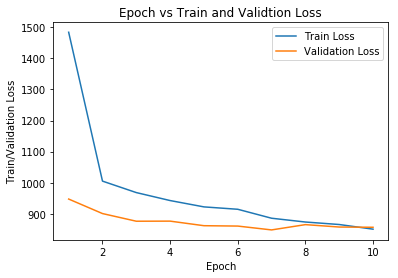

In [46]:
loss_df = pd.DataFrame(model_hist.history)

plt.plot(loss_df.index+1, loss_df.loss, label='Train Loss')
plt.plot(loss_df.index+1, loss_df.val_loss, label='Validation Loss')
plt.title('Epoch vs Train and Validtion Loss')
plt.xlabel('Epoch')
plt.ylabel('Train/Validation Loss')
plt.legend()

In [43]:
# print out model rmse!
print('Train rmse is:', np.sqrt(mean_squared_error(y_train,model.predict(X_train))))

print('Validation rmse is:', np.sqrt(mean_squared_error(y_val,model.predict(X_val))))

print('Test rmse is:', np.sqrt(mean_squared_error(y_test,model.predict(scaler.transform(X_test)))))

Train rmse is: 26.69698880472282
Validation rmse is: 29.276754956750143
Test rmse is: 30.04642782553542


In [44]:
# print model rmsle
print('Train rmsle is:', rmsle(y_train,model.predict(X_train)))

print('Validation rmsle is:', rmsle(y_val,model.predict(X_val)))

print('Test rmsle is:', rmsle(y_test,model.predict(scaler.transform(X_test))))

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Train rmsle is: price    0.542516
dtype: float64
Validation rmsle is: price    0.556435
dtype: float64
Test rmsle is: price    0.555905
dtype: float64


In [133]:
## serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("trial_4.h5")
print("Saved model to disk")

Saved model to disk


## NN Trials

### Trial 1
- learning rate (lr): 0.01
- num_epochs = 30
- batch_size = 1958
- item desc: **500** (max features for tf-idf is 500)
- item name: **100** (max features for tf-idf is 100)
- brand frequency: **500** (only one-hot encode brands that appear more than 500 times)
- test/train split: 0.2 (20% split)
- test/val split: 0.2 (20% split)

In [44]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               406528    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 264)               135432    
_________________________________________________________________
batch_normalization_2 (Batch (None, 264)               1056      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               33920     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total para

### Trial 1 Results
- Simpler architecture withouto dropouts and only 3 layers
- By **epoch 7** got are train and val mse of **788 and 1011**
- There is definitely overfitting with the data
- Did not let the model complete training due to overfitting

### Trial 2
- learning rate (lr): 0.01
- num_epochs: 10
- batch_size: 1201
- item desc: **500**
- item name: **100**
- brand frequency: **500**
- test/train split: 0.2 (20% split)
- test/val split: 0.2 (20% split)

Added dropouts to the model architecture to prevent the overfitting of the model on the train data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               406528    
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 264)               135432    
_________________________________________________________________
batch_normalization_9 (Batch (None, 264)               1056      
_________________________________________________________________
dropout_6 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               33920     
__________

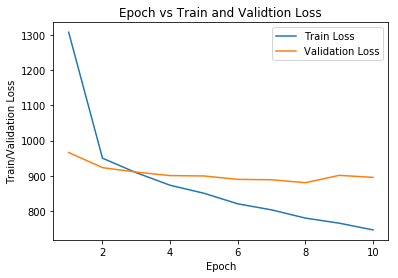

In [68]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

loss_dict = {'val_loss': 
             [966.1777982802738, 923.2987540033276, 910.6167190149442, 900.7386665006188, 
              899.6558118729856, 890.0330886337122, 888.9407532112936, 880.5596371782096, 
              901.4239693127035, 895.6790476066067], 
             'loss': [1307.2278784643245, 950.0663086323799, 908.8625140612638, 873.2989976327631,
                      850.6475863299793, 820.6866712352897, 803.5523838477799, 780.234757358213, 
                      765.7939360799669, 746.6974637961085]
            }
loss_df_2 = pd.DataFrame(loss_dict)

plt.plot(loss_df_2.index+1, loss_df_2.loss, label='Train Loss')
plt.plot(loss_df_2.index+1, loss_df_2.val_loss, label='Validation Loss')
plt.title('Epoch vs Train and Validtion Loss')
plt.xlabel('Epoch')
plt.ylabel('Train/Validation Loss')
plt.legend()

### Trial 2 Results
- Train RMSE: **24 **
- Validation RMSE: **29.93**
- Test RMSE: **30.19**
- It is evident that the model begins overfitting the train data around epoch 5.
- Will increase the size of the training data and add another hidden layer to test if this reduces the overfitting problem

### Trial 3
- learning rate (lr): 0.01
- num_epochs: 10
- batch_size: 1201
- item desc: 500
- item name: 100
- brand frequency: 500
- test/train split: 0.15
- test/val split: 0.15

Added another hidden layer and increases size of training data to prevent overfitting

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              813056    
_________________________________________________________________
batch_normalization_17 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 264)               135432    
__________

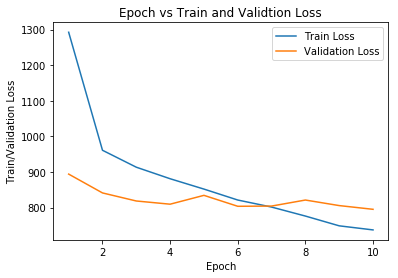

In [70]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
model.summary()

loss_dict_3 = {'val_loss': [893.9534322359361, 841.067386748752, 818.4087141964712, 809.4169764956102, 
                            834.2768080661359, 803.5231950861271, 804.1527677665265, 821.0994145126018, 
                            805.4967043422906, 795.0388555763315], 
               'loss': [1292.4868833472963, 960.9122608191396, 913.3295550593649, 880.9264346034723, 
                        851.8584188117563, 821.1068513949689, 801.3444464967874, 776.073875642645, 
                        748.6214976337192, 737.14988974773]}
loss_df_3 = pd.DataFrame(loss_dict_3)

plt.plot(loss_df_3.index+1, loss_df_3.loss, label='Train Loss')
plt.plot(loss_df_3.index+1, loss_df_3.val_loss, label='Validation Loss')
plt.title('Epoch vs Train and Validtion Loss')
plt.xlabel('Epoch')
plt.ylabel('Train/Validation Loss')
plt.legend()

### Trial 3 Results
- Train RMSE: **23.64**
- Validation RMSE: N/A
- Test RMSE: N/A
- Validation loss is less than training loss in the beginning until epoch 7. Thereafter, the model begins overfitting slightly again.
- This model does well until it begins overfitting around the 9th epoch. 
- For the next trail, I will lower the learning rate and increase the number of item desc features (give more data)

### Trial 4
- learning rate (lr): 0.002
- num_epochs: 10
- batch_size: 2213
- item desc: 800
- item name: 100
- brand frequency: 500
- test/train split: 0.15
- test/val split: 0.15

Increase item description max features from 500 to 800 and reduced learning rate from 0.01 to 0.002

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1024)              813056    
_________________________________________________________________
batch_normalization_27 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_24 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 264)               135432    
__________

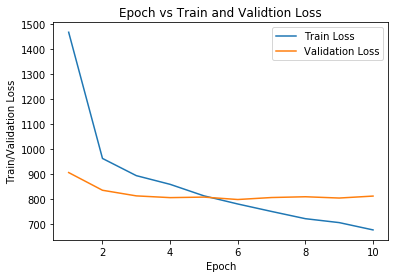

In [72]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
model.summary()

loss_dict_4 = {'val_loss': [906.4580717346178, 835.6651374563694, 813.2003856181778, 806.1938992032306, 
                            808.3237570014784, 798.6526052884393, 806.605135044787, 809.7007012279332, 
                            804.5712916554536, 812.387696434122], 
               'loss': [1467.4912353531922, 962.8633080093233, 894.1208327768919, 859.3493277620055, 
                        813.3187347186795, 780.7855090206166, 750.9078773969164, 721.9841835724127, 
                        706.3253258693578, 677.1003780915596]}
loss_df_4 = pd.DataFrame(loss_dict_4)

plt.plot(loss_df_4.index+1, loss_df_4.loss, label='Train Loss')
plt.plot(loss_df_4.index+1, loss_df_4.val_loss, label='Validation Loss')
plt.title('Epoch vs Train and Validtion Loss')
plt.xlabel('Epoch')
plt.ylabel('Train/Validation Loss')
plt.legend()

### Trial 4 Results
- Train RMSE: **23.01**
- Validation RMSE: **29.03**
- Test RMSE: **29.34**
- Same result as trail 3, model is overfitting
- Since brand name seems to have more of an effect on the price of an item, I will increase the number of brand names OHE

### Trial 5
- learning rate (lr): 0.002
- num_epochs: 10
- batch_size: 2103
- item desc: **100**
- item name: **50**
- brand frequency: **50**
- test/train split: 0.15
- test/val split: 0.15

Reduced the number of item description max features from 800 to 50 and increased the number of brand names OHE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 1024)              813056    
_________________________________________________________________
batch_normalization_37 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_34 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_38 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 264)               135432    
__________

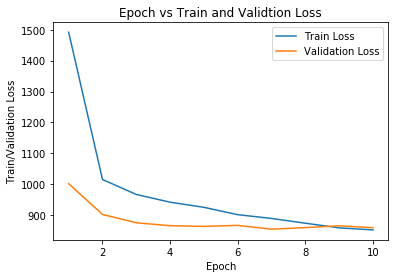

In [74]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
model.summary()

loss_dict_5 = {'val_loss': [1002.2089562332196, 902.7072203370219, 875.7005728521905, 866.2994180715033, 
                            863.9700487145387, 867.2800421080999, 855.0556076345993, 860.1328602809011, 
                            865.9426900054893, 859.8690775757033], 
               'loss': [1491.8377342006727, 1015.6936724313605, 967.2383519632051, 942.2625138568557, 
                        925.7084107589776, 901.9262619875876, 889.6971335113438, 874.3190762380946, 
                        859.341434463773, 852.649874532961]}
loss_df_5 = pd.DataFrame(loss_dict_5)

plt.plot(loss_df_5.index+1, loss_df_5.loss, label='Train Loss')
plt.plot(loss_df_5.index+1, loss_df_5.val_loss, label='Validation Loss')
plt.title('Epoch vs Train and Validtion Loss')
plt.xlabel('Epoch')
plt.ylabel('Train/Validation Loss')
plt.legend()

### Trial 5 Results
- Train RMSE: **26.76**
- Validation RMSE: **29.32**
- Test RMSE: **30.15**
- This is the best model so far as it has the least ampint of overfitting as seen in the graph above. I trained the model for 10 epochs as a start, so it would be nice to train the model with a higher number of epochs


After doing some research, I realized that I may be mixing dense and sparse eatures together (sparse feature could be the tf-idf features and dense features could be the rest). The model may be overfitting on the dense features. To test this theory out, I derived separate NN model for the tf-idf features and one for the rest. This may give us some insight into why the model is overfitting

### Trial 6 (Sparse Features)
- learning rate (lr): 0.002
- num_epochs: 10
- batch_size: 2103
- item desc: **1500**
- item name: 0
- test/train split: 0.15
- test/val split: 0.15

Reduced the number of item description max features from 800 to 50 and increased the number of brand names OHE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 1024)              813056    
_________________________________________________________________
batch_normalization_52 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_49 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_53 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_50 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 264)               135432    
__________

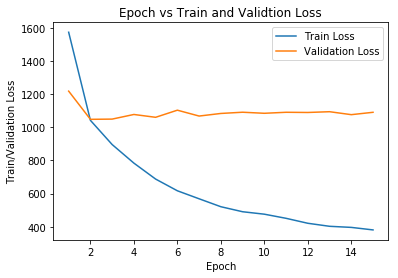

In [77]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
model.summary()

loss_dict_6 = {'val_loss': [1217.6416338833594, 1047.5823814230514, 1048.9667078853502, 1076.8766861056768, 
                            1059.8251634824612, 1102.7695363280557, 1067.353624158997, 1083.0141257887979, 
                            1090.4227442875224, 1084.03840107145, 1090.1185013321362, 1088.940090125215, 
                            1093.5605033395357, 1075.7294467749698, 1089.9973991865206], 
               'loss': [1572.8783934025064, 1041.604502517444, 895.4889809983421, 783.4881842577598, 
                        687.1998442333631, 616.595347463793, 568.280334914395, 520.4557500252855, 
                        490.2046975656187, 475.43665048506546, 450.50989299543585, 420.6035281428809, 
                        402.35682913674157, 395.7445517955127, 380.5324726923594]}

loss_df_6= pd.DataFrame(loss_dict_6)

plt.plot(loss_df_6.index+1, loss_df_6.loss, label='Train Loss')
plt.plot(loss_df_6.index+1, loss_df_6.val_loss, label='Validation Loss')
plt.title('Epoch vs Train and Validtion Loss')
plt.xlabel('Epoch')
plt.ylabel('Train/Validation Loss')
plt.legend()

### Trial 6 Results
- Train RMSE: **23.15**
- Validation RMSE: **33.01**
- Test RMSE: **~33.00**
- Lots of overfitting, but it is interesting to not that the training accuracy does go down all the way to 400 MSE for 15 epochs. This means the description of the item has an impact on predicting prices

### Trial 7 (Dense Features)
- learning rate (lr): 0.002
- num_epochs: 15
- batch_size: 2213
- brand frequency: **100**
- test/train split: 0.1
- test/val split: 0.1

No item description or item name features used for this model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 512)               406528    
_________________________________________________________________
batch_normalization_61 (Batc (None, 512)               2048      
_________________________________________________________________
dense_75 (Dense)             (None, 264)               135432    
_________________________________________________________________
batch_normalization_62 (Batc (None, 264)               1056      
_________________________________________________________________
dense_76 (Dense)             (None, 128)               33920     
_________________________________________________________________
batch_normalization_63 (Batc (None, 128)               512       
_________________________________________________________________
dense_77 (Dense)             (None, 64)                8256      
__________

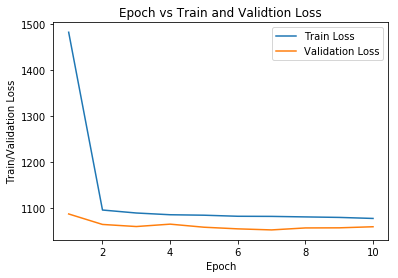

In [80]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
# model.add(Dropout(0.8))

model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(1))
model.summary()

loss_dict_7 = {'val_loss': [1086.2720, 1063.3914,1058.8141, 1064.0263, 1057.3300, 1053.7492, 1051.4364,
                           1055.7563, 1055.9923, 1058.3496], 
               'loss': [1482.9186, 1094.8557, 1088.3559, 1084.5598, 1083.5474, 1081.2210, 1080.9597, 
                       1079.8223, 1078.7325, 1076.4778]}
loss_df_7 = pd.DataFrame(loss_dict_7)

plt.plot(loss_df_7.index+1, loss_df_7.loss, label='Train Loss')
plt.plot(loss_df_7.index+1, loss_df_7.val_loss, label='Validation Loss')
plt.title('Epoch vs Train and Validtion Loss')
plt.xlabel('Epoch')
plt.ylabel('Train/Validation Loss')
plt.legend()

### Trial 7 Results
- Train RMSE: N/A
- Validation RMSE: N/A
- Test RMSE: N/A
- Stopped the model early as it was not improving over 10 epochs
- Stuck around 1100 rmse. This possibly shows how important the item description and item name field are in predicting the price.

# Future Improvements
- Kfold to train the model
- Separate train and test data at the beginning and use fit_transform for train vs transform for test data
- Add regulization term to reduce the overfitting